In [12]:
import json

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import osmnx as ox
import pandas as pd
from mappymatch.constructs.trace import Trace
from mappymatch.maps.nx.nx_map import NxMap
from mappymatch.maps.nx.readers.osm_readers import parse_osmnx_graph, NetworkType
from mappymatch.matchers.lcss.lcss import LCSSMatcher

import bachelors_thesis.util as util

In [13]:
data_path = "../../data"

In [14]:
## Load road graph
road_graph_ox_og = util.load_graph(f"{data_path}/road_graph/road_graph_ox_nsl.pickle")
road_graph_ox = util.load_graph(f"{data_path}/road_graph/road_graph_ox_sim_con_35_nsl_sc.pickle")

In [15]:
map = NxMap(parse_osmnx_graph(road_graph_ox, network_type=NetworkType.DRIVE))

trajectories = list()
with open(f"{data_path}/dataset/trajectories.json", mode="r", encoding="utf-8") as file:
    for line in file:
        trajectory = json.loads(line)
        trajectory["xyt"].sort(key=lambda l: l[2])
        trace = list()
        for x, y, _ in trajectory["xyt"]:
            gps_points = util.xy_to_epsg4326(np.array([[x, y]]))
            lon = gps_points[0, 0]
            lat = gps_points[0, 1]
            trace.append([lon, lat])
        trace = pd.DataFrame(trace, columns=["longitude", "latitude"])
        trajectories.append({"vehicle_id": trajectory["vehicle_id"], "trace": trace})

{'osmid': 269871548, 'highway': 'motorway', 'lanes': '3', 'name': '珠三角环线高速', 'oneway': True, 'ref': 'G94', 'reversed': False, 'length': 102.97151940836191, 'speed_kph': 94.19354838709677, 'travel_time': 3.9354868376620513, 'kilometers': 0.10297151940836191}
{'osmid': 376066067, 'highway': 'motorway', 'lanes': '4', 'name': '沈海高速 深岑高速', 'oneway': True, 'ref': 'G15;G2518', 'reversed': False, 'length': 104.51174532252416, 'speed_kph': 100.0, 'travel_time': 3.76242283161087, 'maxspeed': '100', 'kilometers': 0.10451174532252416}
{'osmid': 1299070562, 'highway': 'motorway_link', 'lanes': '2', 'oneway': True, 'reversed': False, 'length': 14.789950425458922, 'speed_kph': 40.0, 'travel_time': 1.331095538291303, 'maxspeed': '40', 'kilometers': 0.014789950425458923}
{'osmid': 680371235, 'highway': 'trunk_link', 'lanes': '1', 'oneway': True, 'reversed': False, 'length': 41.28761147362509, 'speed_kph': 43.14500594568972, 'travel_time': 3.4450198359492714, 'kilometers': 0.04128761147362509}
{'osmid':

                          road_id  \
0     (5960373497, 5218391835, 0)   
1     (5218391835, 2685669057, 0)   
2     (2685669057, 5218391840, 0)   
3     (5218391840, 5960373477, 0)   
4    (5960373477, 11911586364, 0)   
5    (11911586364, 5960373488, 0)   
6    (5960373488, 11911586337, 0)   
7   (11911586337, 11911590193, 0)   
8    (11911590193, 2308734553, 0)   
9     (2308734553, 2308734611, 0)   
10    (2308734611, 2308734595, 0)   
11   (2308734595, 11911586327, 0)   
12   (11911586327, 7252159113, 0)   
13   (7252159113, 10959920190, 0)   
14   (10959920190, 7191811537, 0)   
15    (7191811537, 9145226539, 0)   
16    (9145226539, 9145226545, 0)   
17    (9145226545, 6643608638, 0)   
18    (6643608638, 3960223109, 0)   
19    (3960223109, 3960223111, 0)   
20    (3960223111, 6643608646, 0)   
21    (6643608646, 2358657106, 0)   
22    (2358657106, 2358657128, 0)   
23    (2358657128, 2358654252, 0)   
24    (2358654252, 9148694848, 0)   
25    (9148694848, 5960373601, 0)   
2

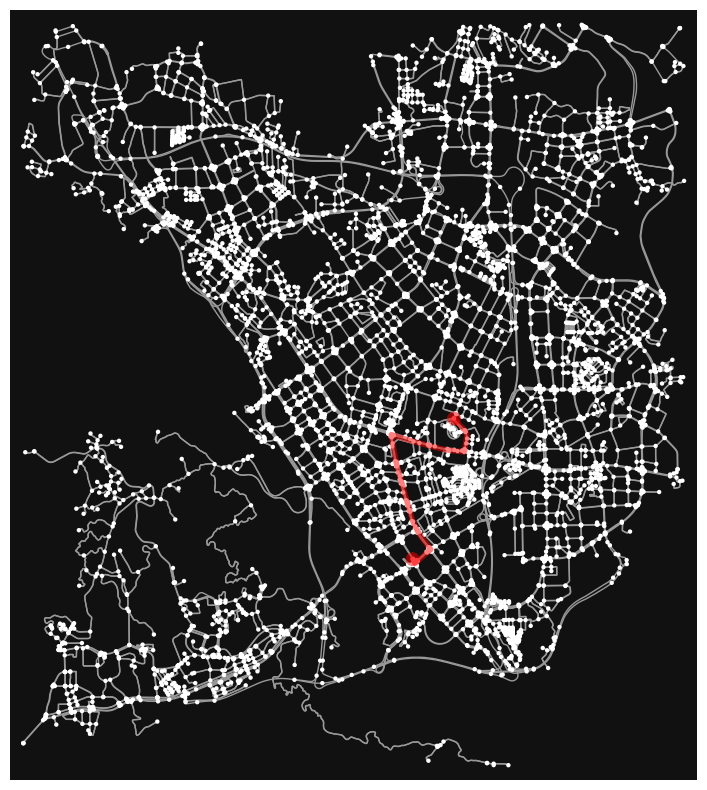

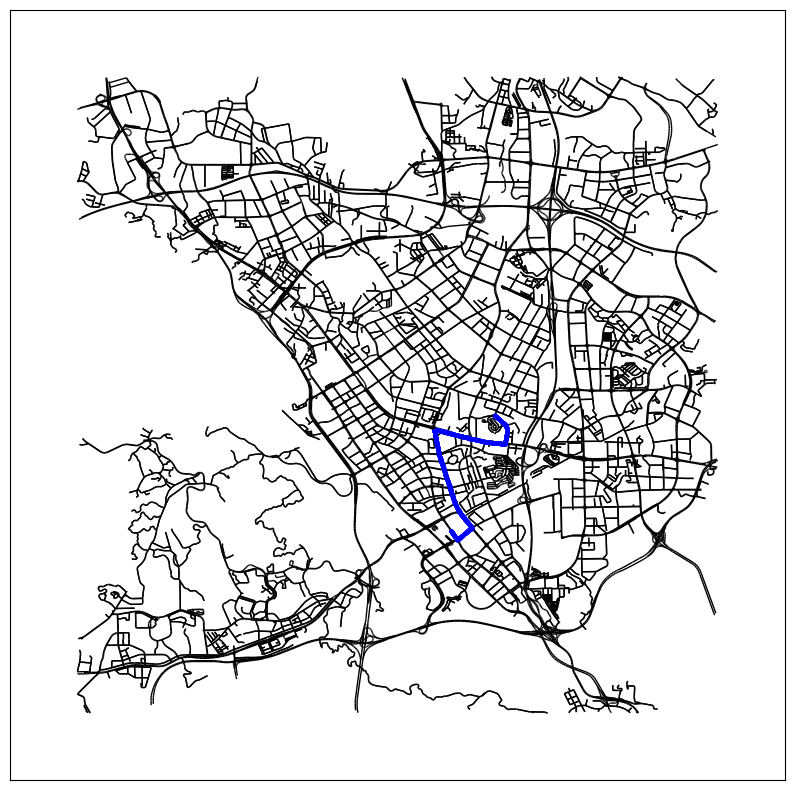

In [16]:
index = 29
trajectory = trajectories[index]["trace"]

trace = Trace.from_dataframe(trajectory, lon_column="longitude", lat_column="latitude")
matcher = LCSSMatcher(map)
match_result = matcher.match_trace(trace)

path_df = match_result.path_to_dataframe()
path = list()
print(path_df)
for _, (u, v) in path_df[["origin_junction_id", "destination_junction_id"]].iterrows():
    path.append(u)
path.append(v)

fig, ax = ox.plot_graph_route(
    road_graph_ox,
    path,
    figsize=(10, 10),
    node_size=10,
    show=True
)

pos = {node: (road_graph_ox_og.nodes[node]["x"], road_graph_ox_og.nodes[node]["y"]) for node in
       road_graph_ox_og.nodes()}

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

nx.draw_networkx_edges(
    road_graph_ox_og,
    pos,
    arrows=False,
    ax=ax
)

trajectory = np.array(trajectory)
ax.scatter(trajectory[:, 0], trajectory[:, 1], s=5, c="blue")

plt.show()